## Libraries and tools



Import/download libraries and tools needed to carry out our tasks.

In [1]:
pip install nltk

In [2]:
pip install contractions

In [3]:
pip install pyspellchecker

In [4]:
# Data load and manipulation
from google.colab import files
import io
 
# DataFrame librery
import pandas as pd
 
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Basic Operations
import numpy as np
import itertools
import pickle
import pandas as pd

# Prepocessing
import re
from sklearn import preprocessing 
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from collections import Counter
from spellchecker import SpellChecker
from contractions import contractions_dict
import contractions

from imblearn.over_sampling import SMOTE

# Models
from sklearn.model_selection import GroupShuffleSplit, train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression

# Natural Language Processing Tools
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download("popular")
nltk.download('vader_lexicon') #sentiment analysis
nltk.download('averaged_perceptron_tagger')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]  

True


## Data loading

First, we define a method to perform the data load.

In [6]:
def upload_files (index_fields = None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    if index_fields:
      df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)
    else:
      df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

We upload the hatred tweets labeled dataset which we'll use to train our models.

In [8]:
print("Please, upload 'labeled_data.csv' file")
labeled_tweets = upload_files(['Unnamed: 0'])
labeled_tweets.head()

Please, upload 'labeled_data.csv' file


Saving labeled_data.csv to labeled_data.csv
User uploaded file "labeled_data.csv" with length 2546446 bytes


,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


We upload a big text that will allow us to apply spelling correction.

In [9]:
print("Please, upload 'big.txt' file")
uploaded = files.upload()

file_name = "big.txt"
raw = uploaded[file_name].decode("utf-8")

Please, upload 'big.txt' file


Saving big.txt to big.txt


We also uploaded a dictionary that contains equivalents between concrete  N-grams and hatred.

In [ ]:
print("Please, upload 'refined_ngram_dict.csv' file")
ngram_dict = upload_files()
ngram_dict.head()

Please, upload 'refined_ngram_dict.csv' file


Saving refined_ngram_dict.csv to refined_ngram_dict.csv
User uploaded file "refined_ngram_dict.csv" with length 3178 bytes


,ngram,prophate
0,allah akbar,0.870
1,blacks,0.583
2,chink,0.467
3,chinks,0.542
4,dykes,0.602


## Preprocessing & Transformation


### Spelling Corrector Declarations

 We declare some methods that will be useful later to perform the spelling correction over the tokens found.

In [10]:
def words(text): 
  return re.findall(r'\w+', text.lower())

In [11]:
# Probability of a word
WORDS = Counter(words(raw))
def P(word, N=sum(WORDS.values())): 
    return WORDS[word] / N

In [ ]:
# Most likely word in correction
def correction(word): 
    return max(candidates(word), key=P)

In [ ]:
def candidates(word): 
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word] or spellingPyhtonChecker(word))

In [ ]:
def known(words): 
    return set(w for w in words if w in WORDS)

In [ ]:
def edits1(word):
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

In [ ]:
def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [ ]:
def spellingPyhtonChecker(word):
  spell = SpellChecker()
  return spell.correction(word)

### Patterns Declarations

 We declare some patterns that will be useful later to identify and replace some special tokens in data.

In [ ]:
# Useful regular expresions
user_re = '@[a-zA-Z0-9_]+:'
mentions_re = '@[a-zA-Z0-9_]+'
#enlaces_re = 'http:\/\/[\/a-zA-Z09_\.]+'
enlaces_re = 'http\S+|www\S+|[A-Za-z0-9\/.:]*\.com(\.[A-Za-z]+)*'
hashtag_re = '#[a-zA-Z0-9_]+'
rt_re = '\!* RT'
censured_re = '&#\d+'
number_re = ' \d+ '

# Useful dictionaries
emojis = {':)' : 'smile', ';)' : 'wink', ':D' : 'big smile', '-.-' : 'bored', }
contractions = { 
"ain't": "am not / are not / is not / has not / have not", "aren't": "are not / am not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not",
 "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he had / he would", "he'd've": "he would have", "he'll": "he shall / he will", "he'll've": "he shall have / he will have",
 "he's": "he has / he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how has / how is / how does", "I'd": "I had / I would", "I'd've": "I would have", "I'll": "I shall / I will", "I'll've": "I shall have / I will have",
 "I'm": "I am", "I've": "I have", "isn't": "is not", "it'd": "it had / it would", "it'd've": "it would have", "it'll": "it shall / it will", "it'll've": "it shall have / it will have", "it's": "it has / it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
 "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
 "shan't've": "shall not have", "she'd": "she had / she would", "she'd've": "she would have", "she'll": "she shall / she will", "she'll've": "she shall have / she will have", "she's": "she has / she is", "should've": "should have", "shouldn't": "should not",
 "shouldn't've": "should not have", "so've": "so have", "so's": "so as / so is", "that'd": "that would / that had", "that'd've": "that would have", "that's": "that has / that is", "there'd": "there had / there would", "there'd've": "there would have", "there's": "there has / there is",
 "they'd": "they had / they would", "they'd've": "they would have", "they'll": "they shall / they will", "they'll've": "they shall have / they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we had / we would", "we'd've": "we would have", "we'll": "we will",
 "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what shall / what will", "what'll've": "what shall have / what will have", "what're": "what are", "what's": "what has / what is", "what've": 
 "what have", "when's": "when has / when is", "when've": "when have", "where'd": "where did", "where's": "where has / where is", "where've": "where have", "who'll": "who shall / who will", "who'll've": "who shall have / who will have", "who's": "who has / who is", "who've": "who have",
 "why's": "why has / why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
 "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you had / you would", "you'd've": "you would have", "you'll": "you shall / you will", "you'll've": "you shall have / you will have", "you're": "you are", "you've": "you have"
}

#we extend the dictionaries from contractions
contractions.update(contractions_dict)

We declare some structures that wil be useful to clean data. 

In [ ]:
# Obtain the stop words we'll remove from data
english_stops = list(stopwords.words('english'))

# Declare unseful characters we'll remove from data
unseful_char = [',', ';', '.', '’', '!', '"', '_', '$', '%', '&amp', '&', '/', '(', ')', '=', '_',
                'ˆ', '*', '¡']

# Extend the stop words set with the unseful characters to remove it in case they alone constitute a token
english_stops.extend(list(unseful_char))

english_stops = set(english_stops)

# Declare a regular expresion that will help us removing the unseful characters from the tokens
unseful_char_re = ""
for r in unseful_char:  
  unseful_char_re += '\\' + r + '|' 

unseful_char_re = unseful_char_re[:-1]

In [ ]:
unseful_char_re

In [ ]:
english_stops

We declare some methods that will be useful later to detect some especials tokens like hashtag, count retweets or censured words by twitter.

In [ ]:
def subRegularExpressions(tweet):
    tweet = re.sub(user_re, 'user', tweet)
    tweet = re.sub(mentions_re, 'mention', tweet)
    tweet = re.sub(enlaces_re, 'url', tweet)
    tweet = re.sub(censured_re, 'curse', tweet)
    tweet = re.sub(hashtag_re, 'hashtag', tweet)
    tweet = re.sub(number_re, 'number', tweet)
    
    return re.sub(rt_re, '', tweet)

In [ ]:
def countRT(tweet):
    rt_string = re.findall(rt_re, tweet)
    if len(rt_string) == 0:
      return 0
    else:
      return len(re.findall(r'!', rt_string[0]))

In [ ]:
def ngram_value(ngram):
  t = ngram_dict.loc[lambda df: df['ngram'] == ngram]
  if len(t) != 0:
    return t['prophate'].iloc[0]
  else:
    return 0

### Preprocessing Steps

we take a look at the original dataset so we can see the changes that occur during pre-test

In [ ]:
labeled_tweets.head()

In [ ]:
other_features = pd.DataFrame(columns = ['rts', 'sentences', 'words', 'curse', 'urls', 'hashtag'])

First, we have to detect some patterns in tweets, to delete or replace them. We count retweets and sustituve some of that patterns.

In [ ]:
other_features['rts'] = labeled_tweets['tweet'].apply(lambda L: countRT(str(L)))
labeled_tweets['tweet'] = labeled_tweets['tweet'].apply(lambda L: subRegularExpressions(str(L)))

Then, we count sentences, words, censured words, urls and hashtag from tweets.

In [ ]:
other_features['sentences'] = labeled_tweets['tweet'].apply(lambda L: len(list(filter(None, L.split('.')))) +
                                                            len(list(filter(None, L.split('?')))) + 
                                                            len(list(filter(None, L.split('!')))) - 2) 
other_features['words'] = labeled_tweets['tweet'].apply(lambda L: len(L.split()))
other_features['curse'] = labeled_tweets['tweet'].apply(lambda L: len(re.findall('curse',L)))
other_features['urls'] = labeled_tweets['tweet'].apply(lambda L: len(re.findall(' url ',L)))
other_features['hashtag'] = labeled_tweets['tweet'].apply(lambda L: len(re.findall('hashtag',L)))
other_features.head()

We inizialize fields 'sentiments' and 'n-gram'.

In [ ]:
other_features['ngram_value'] = 0
other_features['sentiments'] = 0

We must detect n-grams from tweets at the begining because we are going to replace some unseful information like stop words that n-grams contains.

In [ ]:
for k in ngram_dict['ngram']:
  for tweet in labeled_tweets['tweet']:
    if k in tweet:
      try:
        other_features.loc[labeled_tweets['tweet'].loc[lambda L: L == tweet].index[0], 'ngram_value'] += other_features.at[labeled_tweets['tweet'].loc[lambda L: L == tweet].index[0], 'ngram_value'] + ngram_value(k)
      except:
        pass

In [ ]:
#PRUEBAS
other_features.loc[other_features['ngram_value'] > 0]

In [ ]:
other_features

We have to tokenize the tweets, splitting word by word each tweet.

In [ ]:
labeled_tweets_tokanized = [word_tokenize(tweet) for tweet in labeled_tweets['tweet']]

We replace contractions and emoticones by the full form of these, using two dictionaries. The contractions dictionary was extracted from: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [ ]:
labeled_tweets_tokanized_noconst = []

for tweet in labeled_tweets_tokanized:

  new_tweet_tokanized = []

  for token in tweet:
    # Check if its a contraction
    if token in contractions.keys():
      print("Contraction '" + token + "' transformed in '" + contractions[token] + "'")
      for new_token in contractions[token].split(" "):
        new_tweet_tokanized.append(new_token)
    else:
      # If isnt a constraction, we check if its an emoticon
      if token in emojis.keys():
        print("Emoji '" + token + "' transformed in '" + emojis[token] + "'")
        new_tweet_tokanized.append(emojis[token])
      else:
        new_tweet_tokanized.append(token)
      

  labeled_tweets_tokanized_noconst.append(new_tweet_tokanized)

We make some preprocessing to data, in order to clean and prepare data for the algorithms.

In [ ]:
clean_labeled_tweets_tokenized = []

for tweet in labeled_tweets_tokanized_noconst:
  result = []

  # Remove the tokens that belong to the stop words set
  t_list = [token for token in tweet if token not in english_stops]

  # Iterate over each token remaining
  for t in t_list:

    # Remove all capital letters
    t = t.lower()
    # Remove unseful chars from the token in case exists
    t = re.sub(unseful_char_re, "", t)
    # Correct wrong words using spelling corrector methods declared previously
    t = correction(t)
    
    result.append(t)

  clean_labeled_tweets_tokenized.append(result)  

Then, we lemmatize all terms to obtain original word.

In [ ]:
lemmatizer = WordNetLemmatizer()

clean_labeled_tweets_lemmatized = [[lemmatizer.lemmatize(word) for word in tweet] for tweet in clean_labeled_tweets_tokenized]

The last step of preprocessing is to remove repeated following words. 

In [ ]:
preprocessed_tweets = []

for tweet in clean_labeled_tweets_lemmatized:
  token_before = ""
  new_tweet = []
  for token in tweet:

    if token != token_before:
      new_tweet.append(token)
      token_before = token
    else:
      print("Repeated word '" + token_before + "' removed")
  preprocessed_tweets.append(new_tweet)


In [ ]:
pd.set_option('display.max_colwidth', -1)
labeled_tweets['tweet'].head()


## Vectorization

Once we have all the tweets preprocessed, let's vectorize every tweet by following different configurations

###TFIDF

In [14]:
# First, we detokenize every tweet
X_raw = [TreebankWordDetokenizer().detokenize(tweet) for tweet in preprocessed_tweets]

# Then, we define our vectorizer, using the TfidfVectorizer class from sklearn
vectorizer = TfidfVectorizer(min_df=1)

# Fit and transform over our data
X_TFIDF = vectorizer.fit_transform(X_raw)

# Show results
print(vectorizer.vocabulary_)
print(X_TFIDF.toarray())

{'user': 12779, 'woman': 13599, 'not': 8322, 'complain': 2696, 'cleaning': 2511, 'house': 5913, 'amp': 636, 'man': 7440, 'always': 602, 'take': 11829, 'trash': 12422, 'boy': 1742, 'day': 3201, 'cold': 2606, 'tea': 11895, 'down': 3687, 'bad': 1140, 'coffin': 2599, 'dat': 3180, 'he': 5603, '1st': 86, 'place': 9122, 'mention': 7651, 'dawn': 3199, 'you': 13781, 'ever': 4162, 'fuck': 4860, 'bitch': 1507, 'start': 11420, 'cry': 3057, 'confused': 2760, 'shit': 10766, 'look': 7242, 'like': 7037, 'tyranny': 12613, 'the': 12018, 'hear': 5625, 'might': 7737, 'true': 12499, 'baker': 1165, 'told': 12267, 'curse': 3096, 'of': 8467, 'blow': 1614, 'reclaim': 9825, 'faithful': 4336, 'somebody': 11178, 'still': 11483, 'fucking': 4873, 'hoe': 5785, 'sit': 10922, 'hate': 5554, 'another': 735, 'got': 5194, 'much': 7975, 'going': 5150, 'cause': 2203, 'am': 604, 'tired': 12236, 'big': 1457, 'birch': 1484, 'coming': 2654, 'skinny': 10953, 'girl': 5082, 'get': 5047, 'back': 1119, 'that': 12009, 'hobby': 5781, 

In [15]:
X_TFIDF.shape

(24783, 13839)

### TFIDF + N-grams

In [16]:
# Define our vectorizer, using the TfidfVectorizer class from sklearn
vectorizer_ngrams = TfidfVectorizer(ngram_range=(1, 3), min_df=3)

# Fit and transform over our data
X_TFIDF_Ngrams = vectorizer_ngrams.fit_transform(X_raw)

# Show results
print(vectorizer_ngrams.vocabulary_)
print(X_TFIDF_Ngrams.toarray())

{'user': 16539, 'woman': 18077, 'not': 11545, 'complain': 3408, 'cleaning': 3257, 'house': 7518, 'amp': 631, 'man': 9853, 'always': 430, 'take': 15308, 'trash': 16154, 'user woman': 17328, 'woman not': 18092, 'not complain': 11592, 'house amp': 7519, 'take trash': 15335, 'boy': 2555, 'day': 4156, 'cold': 3315, 'tea': 15409, 'down': 4548, 'bad': 1221, 'coffin': 3313, 'dat': 4119, 'he': 6930, '1st': 17, 'place': 12968, 'user boy': 16625, 'dat he': 4128, 'mention': 10068, 'dawn': 4150, 'you': 18332, 'ever': 4881, 'fuck': 5510, 'bitch': 1838, 'start': 14912, 'cry': 3642, 'confused': 3436, 'shit': 14247, 'user you': 17341, 'you ever': 18364, 'ever fuck': 4887, 'fuck bitch': 5529, 'bitch start': 2289, 'start cry': 14915, 'cry you': 3651, 'user you ever': 17345, 'look': 9483, 'like': 9048, 'tyranny': 16428, 'user mention': 16925, 'mention look': 10394, 'look like': 9500, 'like tyranny': 9256, 'user mention look': 16975, 'mention look like': 10395, 'look like tyranny': 9516, 'the': 15586, 'hea

In [17]:
# Build a DataFrame using the output of the vectorizer as data. We'll use this DataFrame to add other features like POS tagging.
features_df = pd.DataFrame(data=X_TFIDF_Ngrams.toarray(), columns=vectorizer_ngrams.get_feature_names())
features_df

,0221,0221 numberurl,10,100,1000,10000,10th,11,111,12,13,14,14th,15,16,17,18,1st,1st date,1st date dont,1st person,20,20 are,200,200 date,2000,201,21,210,214,22,23,24,247,25,250,26,28,29,2nd,...,you want,you wo,you wo not,you would,youcurse,youcurse bitch,youcurse curse,youcurse little,youcurse little bitch,young,young age,young berg,young birch,young bitch,young boy,young japanese,young japanese girlcurse,young lady,young nigh,young night,young rich,young sicca,young thus,younger,your,your bitch,your fucking,your fussy,your girl,your opinion,your opinion irrelevant,youth,ze,zero,zero birch,zero hoe,zimmerman,zip,zone,zone nn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.304751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.260361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### TFIDF + N-grams + POS Tagging

In [18]:
# Obtain every element from the vocabulary of the vectorizer
pos_vocab = [v for i, v in enumerate(vectorizer.get_feature_names())]

# Calculate the pos tags for each of this elements of the vocabulary
tags = nltk.pos_tag(pos_vocab)

# Builds a dictionary which contains the pos tag dor each element of the vocabulary
pos_dictionary = {}
for tag in tags:
  word, pos_tag = tag
  pos_dictionary[word]= pos_tag

Then, we add the columns we need to store the number of occurrences of each POS tag

In [19]:
possible_POS_tags = list(pos_dictionary.values())
possible_POS_tags.sort()
possible_POS_tags = set(possible_POS_tags)

for tag in possible_POS_tags:
  features_df[tag] = 0

In [20]:
for i, tweet in enumerate(preprocessed_tweets):
  pos_ocur = {}
  for p in possible_POS_tags:
    pos_ocur[p] = 0

  for token in tweet:
    if token in pos_dictionary:
      pos_ocur[pos_dictionary[token]] += 1

  for k in list(pos_ocur.keys()):
    features_df.loc[i, k] = pos_ocur[k]

### TFIDF + N-grams + POS Tagging + Other Features


####Sentiment Intensity Analyzer

In [21]:
#Define figure where load Sentiment Intensity Analyzer of dataset
sns.set(rc={'figure.figsize':(30,1)})
def visualise_sentiments(data):
  sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

In [22]:
# Obtain sentiments intensity from tweet
def sentiment_analize(tweet):
  sentiment_analyzer  = SentimentIntensityAnalyzer() 
  sentiment = sentiment_analyzer.polarity_scores(tweet)
  sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']

  #visualise_sentiments({
  #    "Sentence":["SENTENCE"] + tweet.split(),
  #    "Sentiment":[sentiment_analyzer.polarity_scores(tweet)["compound"]] + [sentiment_analyzer.polarity_scores(word)["compound"] for word in tweet.split()]
  #})
  return sentiment["compound"]


We calculate the sentiments intensity for each of this elements of the preprocessed tweets

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [24]:
other_features['sentiments'] = [sentiment_analize(L) for L in X_raw]

In [25]:
x = other_features['sentiments'].values.reshape(-1, 1) #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
other_features['sentiments'] = x_scaled

In [26]:
other_features.head()

,rts,sentences,words,curse,urls,hashtag,ngram_value,sentiments
0,3,2,23,0,0,0,0.0,0.645192
1,5,2,14,0,0,0,0.0,0.229369
2,7,2,18,0,0,0,0.0,0.024101
3,9,1,7,0,0,0,0.0,0.688768
4,13,1,24,1,0,0,0.0,0.075863


In [27]:
other_features.reset_index(drop=True, inplace=True)
features_df.reset_index(drop=True, inplace=True)

We concat other features, that we calculated previously during preprocessing, and features


In [28]:
features_df = pd.concat([features_df, other_features], axis=1)
features_df.head()

,0221,0221 numberurl,10,100,1000,10000,10th,11,111,12,13,14,14th,15,16,17,18,1st,1st date,1st date dont,1st person,20,20 are,200,200 date,2000,201,21,210,214,22,23,24,247,25,250,26,28,29,2nd,...,zone,zone nn,JJR,NN,VB,WP,NNS,JJ,PRP,UH,VBZ,RBR,VBD,TO,PRP$,IN,DT,CC,RBS,VBP,WRB,WDT,VBN,RP,RB,MD,FW,NNP,WP$,CD,JJS,VBG,rts,sentences,words,curse,urls,hashtag,ngram_value,sentiments
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2,0,0,0,0,0,0,1,3,2,23,0,0,0,0.0,0.645192
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.304751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,5,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,5,2,14,0,0,0,0.0,0.229369
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,5,0,0,0,1,2,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,7,2,18,0,0,0,0.0,0.024101
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,9,1,7,0,0,0,0.0,0.688768
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,2,0,0,0,2,0,0,0,0,2,0,0,0,1,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,13,1,24,1,0,0,0.0,0.075863


# Feature selection

In [29]:
y = np.array(labeled_tweets['class'])
X = features_df.to_numpy()

In [30]:
new_X = SelectKBest(score_func = chi2, k = int(len(X[0])*0.3)).fit_transform(X,y)
new_X.shape

(24783, 5551)

# Classification Algorithms

Using the selected best features, let's use 2 classification algorithms to classify the tweets according to the 'class' field, which values means:

- 0: Hate speech
- 1: Offensive lenguage
- 2: Neither

For this purpose, we'll split our data, using 70% of the dataset for training and the remaining 30% for testing, tuning the different parameters by a cross validation. 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.3, random_state=42)

## SVM

We will use Support Vector Machines as the first algorithm to classiffy tweets. In order to find the best parameters for this algorithm, we are going to use a Grid Search with cross-validation, which will allow us to explore combinations of this parameters. First, we define the model we'll use.

In [ ]:
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC()
model = make_pipeline(pca, svc)

Once we got our model declared, we need to define the set of parameters to be used in the Grid Search.

In [ ]:
param_grid = {'svc__C': [0.1, 1, 10, 50, 100, 1000],  
              'svc__gamma': [0.01, 0.001, 0.0001, 0.00001],
              'svc__kernel': ['rbf']} 

Then, we run the search.

In [ ]:
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, verbose = 3)

# Fit the Grid Search over training data
grid_search.fit(X = X_train, y = y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf, score=0.826, total= 1.1min
[CV] svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf, score=0.816, total= 1.0min
[CV] svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV]  svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf, score=0.820, total= 1.0min
[CV] svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf ....................
[CV]  svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf, score=0.814, total= 1.1min
[CV] svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf ....................
[CV]  svc__C=0.1, svc__gamma=0.01, svc__kernel=rbf, score=0.819, total= 1.1min
[CV] svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf ...................
[CV]  svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf, score=0.806, total=  52.0s
[CV] svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf ...................
[CV]  svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf, score=0.799, total=  52.3s
[CV] svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf ...................
[CV]  svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf, score=0.801, total=  51.2s
[CV] svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf ...................
[CV]  svc__C=0.1, svc__gamma=0.001, svc__kernel=rbf, score=0.798, total=  52.0s
[CV] svc__C=0.1, 

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 110.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=150, random_state=42,
                                            svd_solver='auto', tol=0.0,
                                            whiten=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state

We define a method that will show us the results of the search.

In [ ]:
# Show the N best models(Specified in 'n_top' parameter) given results of Gridsearch Hyperparameter Optimization
def report(results, n_top=3): 
    # Iterate over range between 1 and n_top + 1
    for i in range(1, n_top + 1):
        # Get N-best models in results
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        # For each candidate, show rank, scores and parameters
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


Using the method declared prevoiusly, we are going to print the N best models discovered by our Grid Search

In [ ]:
#@title Number of models to get from Grid Search results
N_best_models = 5 #@param {type:"slider", min:1, max:15, step:1}

report(grid_search.cv_results_, n_top = N_best_models)

Model with rank: 1
Mean validation score: 0.887 (std: 0.006)
Parameters: {'svc__C': 1000, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.886 (std: 0.005)
Parameters: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.883 (std: 0.004)
Parameters: {'svc__C': 100, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}

Model with rank: 4
Mean validation score: 0.883 (std: 0.005)
Parameters: {'svc__C': 50, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Model with rank: 5
Mean validation score: 0.882 (std: 0.005)
Parameters: {'svc__C': 1000, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}



Then, we get the best model directly from the Grid Search class, and we predict over test data to see the performance of the model.

In [ ]:
#best_model = grid_search.best_estimator_
best_model = SVC(C = 1000.0, kernel = 'rbf', gamma = 0.0001)
best_model.fit(X_test, y_test)
y_pred = best_model.predict(X_test)

Finally, we show the performance of our best estimator using the classification report provided by Scikit Learn.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.08      0.14       427
           1       0.92      0.95      0.93      5747
           2       0.76      0.89      0.82      1261

    accuracy                           0.89      7435
   macro avg       0.72      0.64      0.63      7435
weighted avg       0.87      0.89      0.87      7435



We also display the confusion matrix which shows us the relation between predicted labels by the model and the true label.

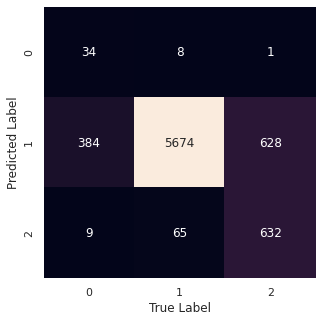

In [ ]:
plt.figure(figsize=(6,6))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2])
plt.xlabel('True Label')
plt.ylabel('Predicted Label');

As we can see in the matrix, the model tends to predict that the most of the tweets belong to the label 1 (Offensive language). 

Class 0, which is a minority in our data set, is where our model fails the most, predicting up to 322 tweets belonging to this class as offensive language. This result is normal, since even for any human being it can be difficult to differentiate between the term offensive language and hate speech.

## Naive Bayes

As we can see in the next cell, our data is imbalanced, and as we know from the SVM results, is very hard to differentiate class 0 and class 1. 

In [32]:
labeled_tweets['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

We try to solve this using synthetic minority oversampling technique.


In [33]:
smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(new_X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Original dataset shape Counter({1: 19190, 2: 4163, 0: 1430})
Resample dataset shape Counter({2: 19190, 1: 19190, 0: 19190})


SVM results aren't bad, but we are going to improve it. For this porpuse, we are going to use Naive Bayes models, which are a group of fast and simple classification algorithms that are often suitable for very high-dimensional datasets like ours.



              precision    recall  f1-score   support

           0       1.00      0.00      0.01       427
           1       0.53      0.00      0.00      5747
           2       0.17      1.00      0.29      1261

    accuracy                           0.17      7435
   macro avg       0.57      0.34      0.10      7435
weighted avg       0.49      0.17      0.05      7435

              precision    recall  f1-score   support

           0       0.80      0.01      0.02       427
           1       0.93      0.81      0.86      5747
           2       0.49      0.95      0.65      1261

    accuracy                           0.78      7435
   macro avg       0.74      0.59      0.51      7435
weighted avg       0.84      0.78      0.78      7435

              precision    recall  f1-score   support

           0       0.56      0.70      0.62       427
           1       0.93      0.93      0.93      5747
           2       0.85      0.77      0.81      1261

    accuracy        

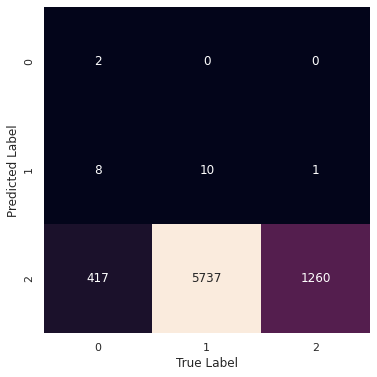

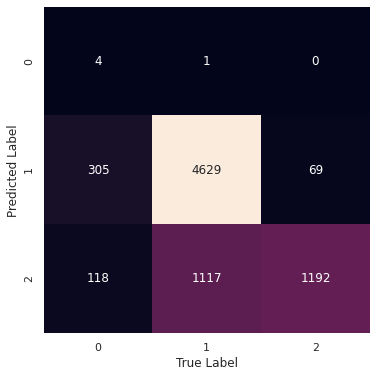

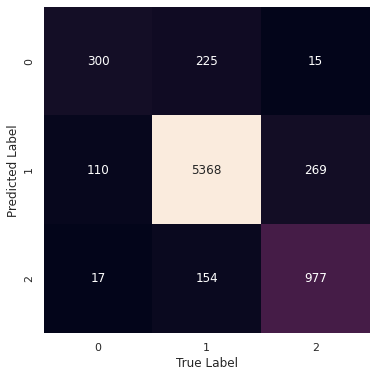

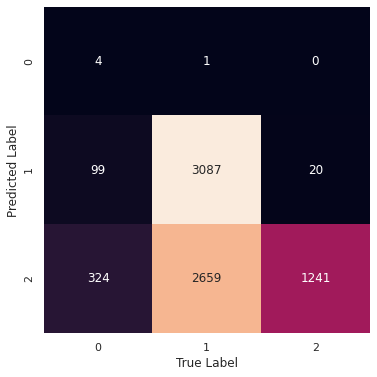

In [34]:
from sklearn.utils.multiclass import unique_labels
# We define different classification models at NaiveBayes
names = ["GaussianNB", "MultiNomialNB", 'BernouilliNB', 'ComplementNB']
classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB()]

kf = KFold(n_splits = 10, shuffle = False)

# Iterate over the classificators
for name, classifier in zip(names, classifiers):
  classifier.fit(X_smote, y_smote)

  

  score = classifier.score(X_test, y_test) #Returns the mean accuracy on the given test data and labels.

  y_pred = classifier.predict(X_test) #Returns model predict to X_test.
  
  print(classification_report(y_test, y_pred)) #we show the performance of our best estimator using the classification report provided by Scikit Learn.

  #We also display the confusion matrix which shows us the relation between predicted labels by the model and the true label.
  plt.figure(figsize=(6,6))
  mat = confusion_matrix(y_test, y_pred)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=[0, 1, 2],
              yticklabels=[0, 1, 2])
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label');

  



In [ ]:
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []

   for n_neighbors in range(1,50):

       fold_accuracy = []

       knn_model = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)

       # We validate the model with cross-validation
       for train_fold, validation_fold in kf.split(X_smote):

          # Train the model
          knn_model.fit(X = X_smote, y = y_smote)

          # Evaluate the model
          y_pred = knn_model.predict(X = X_test)
          mae = mean_absolute_error(y_test, y_pred)
          fold_accuracy.append(mae)

       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, marker='o', label=weights)
   print ('Minimum Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('Mean Absolute Error')      
    
plt.legend()
plt.show() 

# Utility cells for handle intermediate data

Pre-processing tweets is a very time consuming process. That's why we had to find a way to store intermediate data, the pre-processed tweets. For this, we use the Pickle library, which allows us to download Python structures in a proprietary format, and reload them later in a very simple way. In the next cell we can find the code we use to export the preprocessed tweets.

In [ ]:
with open('preprocessed_tweets.pickle', 'wb') as handle:
    pickle.dump(preprocessed_tweets, handle, protocol=pickle.HIGHEST_PROTOCOL)

files.download('preprocessed_tweets.pickle')

In [ ]:
with open('other_features.pickle', 'wb') as handle:
    pickle.dump(other_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

files.download('other_features.pickle')

In [ ]:
with open('vectorizer_ngrams.pickle', 'wb') as handle:
    pickle.dump(vectorizer_ngrams, handle, protocol=pickle.HIGHEST_PROTOCOL)

files.download('vectorizer_ngrams.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In this last cell, we can see the code we used to load this .pickle file back into the notebook.

In [12]:
print("Please, upload 'preprocessed_tweets.pickle' file")
uploaded = files.upload()

file_name = "preprocessed_tweets.pickle"

with open(file_name, 'rb') as f:
  preprocessed_tweets = pickle.load(f)

Please, upload 'preprocessed_tweets.pickle' file


Saving preprocessed_tweets.pickle to preprocessed_tweets.pickle


In [13]:
print("Please, upload 'other_features.pickle' file")
uploaded = files.upload()

file_name = "other_features.pickle"

with open(file_name, 'rb') as f:
  other_features = pickle.load(f)

Please, upload 'other_features.pickle' file


Saving other_features.pickle to other_features.pickle


In [ ]:
print("Please, upload 'other_features_sentiments.pickle' file")
uploaded = files.upload()

file_name = "other_features_sentiments.pickle"

with open(file_name, 'rb') as f:
  other_features = pickle.load(f)

In [ ]:
print("Please, upload 'vectorizer_ngrams.pickle' file")
uploaded = files.upload()

file_name = "vectorizer_ngrams.pickle"

with open(file_name, 'rb') as f:
  vectorizer_ngrams = pickle.load(f)

Please, upload 'vectorizer_ngrams.pickle' file


Saving vectorizer_ngrams.pickle to vectorizer_ngrams.pickle


We upload the hatred tweets labeled dataset which we'll use to train our models.

In [ ]:
print("Please, upload 'labeled_data.csv' file")
labeled_tweets = upload_files(['Unnamed: 0'])
labeled_tweets.head()

Please, upload 'labeled_data.csv' file


Saving labeled_data.csv to labeled_data.csv
User uploaded file "labeled_data.csv" with length 2546446 bytes


,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


We upload a big text that will allow us to apply spelling correction.

In [ ]:
print("Please, upload 'big.txt' file")
uploaded = files.upload()

file_name = "big.txt"
raw = uploaded[file_name].decode("utf-8")

Please, upload 'big.txt' file


Saving big.txt to big.txt


We also uploaded a dictionary that contains equivalents between concrete  N-grams and hatred.

In [ ]:
print("Please, upload 'refined_ngram_dict.csv' file")
ngram_dict = upload_files()
ngram_dict.head()

Please, upload 'refined_ngram_dict.csv' file


Saving refined_ngram_dict.csv to refined_ngram_dict.csv
User uploaded file "refined_ngram_dict.csv" with length 3178 bytes


,ngram,prophate
0,allah akbar,0.870
1,blacks,0.583
2,chink,0.467
3,chinks,0.542
4,dykes,0.602
